# Adversarial Variational Bayes
This notebook contains the code for the STAN example to demonstrate how Adversarial Variational Bayes (AVB) can be used to approximate complex posterior distributions.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pystan
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import ite
from tqdm import tqdm_notebook
import re
import glob
import tensorflow as tf
from tensorflow.contrib import slim
ds = tf.contrib.distributions
st = tf.contrib.bayesflow.stochastic_tensor

In [2]:
# Parameters
M = 1
batch_size = 512
data = {'J': 8 * M,
        'y': [2.8,  0.8, -0.3,  0.7, -0.1,  0.1, 1.8, 1.2] * M,
       'sigma': [0.8, 0.5, 0.8, 0.6,  0.5, .6, 0.5, 0.4] * M,
       'psigma_eta': 100., 'psigma_mu': 100., 'psigma_tau': 100.}

# Parameter for AVB: wether to use adaptive contrast
is_adapt_contrast = True

In [3]:
# Utility functions
def kde(mu, tau, bbox=[-5, 5, -5, 5], xlabel="", ylabel=""):
    values = np.vstack([mu, tau])
    kernel = sp.stats.gaussian_kde(values)

    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_aspect(4/5*abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    xx, yy = np.mgrid[bbox[0]:bbox[1]:100j, bbox[2]:bbox[3]:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = ax.contourf(xx, yy, f, cmap='Blues')

    plt.show()

def scatter(mu, tau, bbox=[-5, 5, -5, 5], xlabel="", ylabel=""):
    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_aspect(4/5*abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
                        
    ax.scatter(mu, tau, edgecolor='none', alpha=0.5)

    plt.show()    

    
def hist(x, xlabel="", ylabel=""):
    fig, ax = plt.subplots()
    ax.hist(x, bins=50)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
    
def heat_map(f, bbox=[-5, 5, -5, 5], xlabel="", ylabel=""):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    N, M = f.shape
    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
                        
    xx, yy = np.mgrid[bbox[0]:bbox[1]:(N*1j), bbox[2]:bbox[3]:(M*1j)]
    cfset = ax.contourf(xx, yy, f, cmap='Reds')
    cset = ax.contour(xx, yy, f, colors='k')
    plt.show()

def heat_map_func(func, data, bbox=[-5, 5, -5, 5], **kwargs):
    xx, yy = np.mgrid[bbox[0]:bbox[1]:100j, bbox[2]:bbox[3]:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(func(positions, data=data).T, xx.shape)
    heat_map(f, bbox, **kwargs)
    

# Models
Select one of the following models by running the associated code.

## Eight schools

In [4]:
model_code = """
data {
  int<lower=0> J; // number of schools 
  real y[J]; // estimated treatment effects
  real<lower=0> sigma[J]; // s.e. of effect estimates 
  real<lower=0> psigma_eta; // prior for eta
  real<lower=0> psigma_mu; // prior for mu
  real<lower=0> psigma_tau; // prior for tau

}
parameters {
  real mu; 
  real tau;
  real eta[J];
}
transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * eta[j];
}
model {
  target += normal_lpdf(y | theta, sigma);
  target += normal_lpdf(eta | 0, psigma_eta);
  target += normal_lpdf(mu | 0, psigma_mu);
  target += normal_lpdf(tau | 0, psigma_tau);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00dad1eb4bc86a34204f8b1210adf4a7 NOW.


In [5]:
param_dim = 2 + data['J']
Ez0 = np.zeros(param_dim, dtype=np.float32)
stdz0 = np.concatenate([
            np.array([data['psigma_mu'], data['psigma_tau']], dtype=np.float32),
            data["psigma_eta"] * np.ones(data['J'], dtype=np.float32)
        ])
def get_logprob(z, data):
    mu = z[:, 0:1]
    tau = z[:, 1:2]
    eta = z[:, 2:]
    theta = mu + tau*eta

    y = tf.constant(data['y'], dtype=tf.float32, shape=(1, data['J']))
    sigma = tf.constant(data['sigma'], dtype=tf.float32, shape=(1, data['J']))
    err = (y - theta)/sigma

    logprob = tf.reduce_sum(
        -0.5 * tf.square(err) - tf.log(sigma) - 0.5*np.log(2*np.pi), [1]
    )
    logprob -= 0.5*tf.reduce_sum(tf.square(mu/data['psigma_mu']), [1])
    logprob -= 0.5*tf.reduce_sum(tf.square(tau/data['psigma_tau']), [1])
    logprob -= 0.5*tf.reduce_sum(tf.square(eta/data['psigma_eta']), [1])
    
    return logprob


## Gauss example

In [ ]:
model_code = """
data {
  int<lower=0> J; // number of schools 
  real y[J]; // estimated treatment effects
}
parameters {
  real mu;
  real logsigma;
}
model {
  target += normal_lpdf(mu | 0, 100);
  target += normal_lpdf(logsigma | 0, 100);
  target += normal_lpdf(y | mu, exp(logsigma));
}
"""

sm = pystan.StanModel(model_code=model_code)

In [ ]:
param_dim = 2
Ez0 = np.array([0., 0.], dtype=np.float32)
stdz0 = np.array([100., 100.], dtype=np.float32)

def get_logprob(z, data):
    mu = z[:, 0:1]
    logsigma = z[:, 1:2]
    y = np.asarray(data['y'], dtype=np.float32).reshape(1, -1)
    err = (y - mu)*tf.exp(-logsigma)

    logprob = tf.reduce_sum(
        -0.5 * tf.square(err) - logsigma - 0.5*np.log(2*np.pi), [1]
    )
    logprob -= 0.5*tf.reduce_sum(z/stdz0.reshape(1, -1), [1])
    return logprob


def get_logprob_np(z, data):
    mu = z[:, 0:1]
    logsigma = z[:, 1:2]
    y = np.asarray(data['y'], dtype=np.float32).reshape(1, -1)
    err = (y - mu)*np.exp(-logsigma)

    logprob = np.sum( 
        -0.5 * err*err - logsigma - 0.5*np.log(2*np.pi), axis=1
    )
    logprob -= 0.5*np.sum(z/stdz0.reshape(1, -1), axis=1)
    return logprob


## Rosenbrock

In [ ]:
param_dim = 2
Ez0 = np.array([0., 0.], dtype=np.float32)
stdz0 = np.array([1000., 1000.], dtype=np.float32)

def get_logprob(z, data):
    x1 = z[:, 0:1]
    x2 = z[:, 1:2]
        
    logprob = tf.reduce_sum(
        -tf.square(x1 - 1) - tf.square(tf.square(x2) - x1), [1]
    )
    return logprob

## Torus

In [ ]:
param_dim = 2
Ez0 = np.array([0., 0.], dtype=np.float32)
stdz0 = np.array([1000., 1000.], dtype=np.float32)

def get_logprob(z, data):
    x1 = z[:, 0:1]
    x2 = z[:, 1:2]
        
    logprob = tf.reduce_sum(
        -tf.square((tf.square(x1) + tf.square(x2)) - 2.), [1]
    )

    return logprob

def torus_np(z):
    x1 = z[:, 0:1]
    x2 = z[:, 1:2]
        
    logprob = np.sum(
        -np.square(x1*x1 + x2*x2 - 2.), axis=1
    )

    return logprob



# AVB definition
The main code for AVB.

In [6]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def standard_normal(shape, **kwargs):
    """Create a standard Normal StochasticTensor."""
    return tf.random_normal(shape)

def posterior(reuse=False):
    with tf.variable_scope("posterior", reuse=reuse) as scope:
        eps = standard_normal([batch_size, param_dim])

        with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.elu):
            net = slim.fully_connected(eps, 128, scope='fc_0')
            
            for i in range(5):
                dnet = slim.fully_connected(net, 128, scope='fc_%d_r0' % (i+1))
                net += slim.fully_connected(dnet, 128, activation_fn=None, scope='fc_%d_r1' % (i+1),
                                            weights_initializer=tf.constant_initializer(0.))
                net = lrelu(net) 

                
            net = slim.fully_connected(net, 128, scope='fc_2')
                
        z = slim.fully_connected(net, param_dim, activation_fn=None, scope='z')

        return z

def adversary(z, reuse=False):
    with tf.variable_scope("adversary", reuse=reuse) as scope:
        with slim.arg_scope([slim.fully_connected], activation_fn=lrelu):
            net = slim.fully_connected(z, 256, scope='fc_0')

            for i in range(20):
                dnet = slim.fully_connected(net, 256, scope='fc_%d_r0' % (i+1))
                net += slim.fully_connected(dnet, 256, activation_fn=None, scope='fc_%d_r1' % (i+1),
                                            weights_initializer=tf.constant_initializer(0.))
                net = lrelu(net) 

        T = slim.fully_connected(net, 1, activation_fn=None, scope='T',
                                weights_initializer=tf.constant_initializer(0.))
        T = tf.squeeze(T, [1])
        return T

In [7]:
tf.reset_default_graph() 
z0 = tf.random_normal([batch_size, param_dim], name="z0")
z_ = posterior()
beta = tf.constant(1.)

if is_adapt_contrast:
    Ez_, Varz_ = tf.nn.moments(z_, [0], keep_dims=True)
    stdz_ = tf.sqrt(Varz_) + 1e-6
    Ez_ = tf.stop_gradient(Ez_)
    stdz_ = tf.stop_gradient(stdz_)
else:
    Ez_ = tf.constant(Ez0.reshape(1, -1), dtype=tf.float32)
    stdz_ = tf.constant(stdz0.reshape(1, -1), dtype=tf.float32)

zr = Ez_ + stdz_ * z0
znorm_ = (z_ - Ez_) / stdz_

logr_ = -tf.reduce_sum(0.5 * tf.square(znorm_) + tf.log(stdz_) + 0.5 * np.log(2*np.pi), [1])
logr_zr = -tf.reduce_sum(0.5 * tf.square(z0) + tf.log(stdz_) + 0.5 * np.log(2*np.pi), [1])
    
if is_adapt_contrast:
    Ti = adversary(z0) - logr_zr
    Td = adversary(znorm_, reuse=True) - logr_
else:
    Ti = adversary(zr) - logr_zr
    Td = adversary(z_, reuse=True) - logr_


logprob = get_logprob(z_, data)
mean_logprob = tf.reduce_mean(logprob)
mean_Td = tf.reduce_mean(Td)
loss_primal = tf.reduce_mean(beta*(logr_ + Td) - logprob)

d_loss_d = tf.reduce_mean(
   tf.nn.sigmoid_cross_entropy_with_logits(logits=Td, labels=tf.ones_like(Td))
)
d_loss_i = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Ti, labels=tf.zeros_like(Ti))
)
loss_dual = d_loss_i + d_loss_d

In [8]:
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "posterior")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "adversary")
popt = tf.train.AdamOptimizer(1e-4, beta1=0.5)
dopt = tf.train.AdamOptimizer(2e-4, beta1=0.5)

grads_primal =  popt.compute_gradients(loss_primal, var_list=pvars)
grads_dual = dopt.compute_gradients(loss_dual, var_list=dvars)

train_primal = popt.apply_gradients(grads_primal)
train_dual = dopt.apply_gradients(grads_dual)

train_step = [train_primal, train_dual]

In [9]:
from tqdm import tqdm_notebook, tnrange

def run_training(sess, data, niter=10000, betas=None, npretrain=0):       
    if betas is None:
        betas = []
        
    for i in tnrange(npretrain, desc="Pretrain"):
        sess.run(train_dual)

    pbar = tnrange(niter+1, desc="Train")
    for i in pbar:
        if i >= np.size(betas):
            beta_i = 1.
        else:
            beta_i = betas[i]
                           
        _, lp, ld, td = sess.run(
                [train_primal, loss_primal, loss_dual, mean_Td],
                feed_dict={beta: beta_i}
        )
        
        sess.run(train_dual)
        sess.run(train_dual)
            
        pbar.set_description("lp=%.3f, ld=%.3f, td=%.3f"  % (lp, ld, td))

def get_samples(sess, nbatches=100):
    zs = np.zeros([nbatches, batch_size, param_dim])
    for i in range(nbatches):
        zs[i] = sess.run(z_)
    zs = zs.reshape(-1, param_dim)
    return zs

def stan_vb(stan_vb_alg="fullrank", niter=10000):
    stan_vb_out = "./vb.out"
    sm.vb(data=data, sample_file=stan_vb_out, algorithm=stan_vb_alg, iter=niter, output_samples=10000, seed=1)
    stan_vb_samples = np.genfromtxt(stan_vb_out, dtype=float, delimiter=',')
    stan_vb_samples = stan_vb_samples[1:, 1:param_dim+1]

    return stan_vb_samples

In [10]:
# Close existing session if available
try:
    sess.close()
except NameError:
    pass
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Model fitting

In [11]:
# Some parameters for the model fitting
iter_max = 100000

In [12]:
# Run HMC
stan_fit = sm.sampling(data=data, iter=500000, thin=50)

In [26]:
# AVB
run_training(sess, data, niter=iter_max, npretrain=0)

In [ ]:
# Multiple VB
stan_vb_samples_mf = stan_vb("meanfield", iter_max)
stan_vb_samples = stan_vb("fullrank", iter_max)


# Visualization

In [27]:
# Parameters for visualization
idx0, idx1 = 0, 1
labels = [r'$\mu$', r'$\tau$', r'$\eta_1$']
xlabel = labels[idx0]
ylabel = labels[idx1]

plt.rc('font', size=16)


## STAN HMC


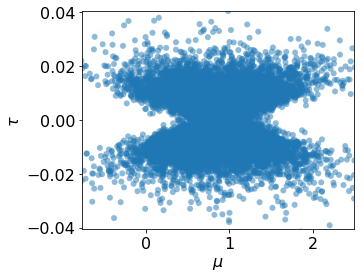

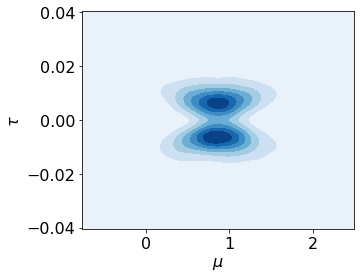

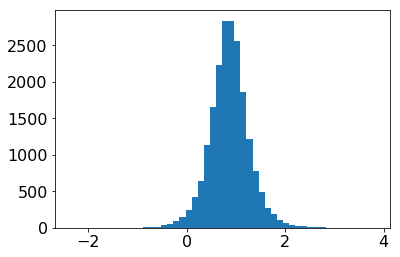

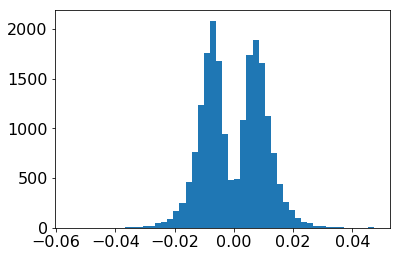

In [28]:
def expand_vec(a):
    if a.ndim == 1:
        return a.reshape(-1, 1)
    else:
        return a
    
stan_res = stan_fit.extract()
q = np.concatenate([expand_vec(l) for l in stan_res.values()], axis=1)

q1 = q[:, idx0]
q2 = q[:, idx1]

q1_mean = q1.mean()
q1_std = q1.std()

q2_mean = q2.mean()
q2_std = q2.std()

bbox = [q1_mean - 4*q1_std, q1_mean + 4*q1_std,
        q2_mean - 4*q2_std, q2_mean + 4*q2_std]
scatter(q1, q2, bbox, xlabel=xlabel, ylabel=ylabel)
kde(q1, q2, bbox, xlabel=xlabel, ylabel=ylabel)
hist(q1)
hist(q2)

## AVB


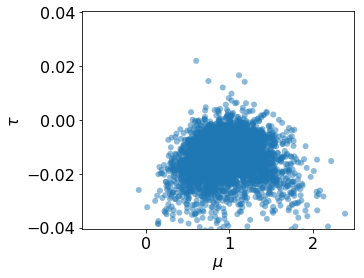

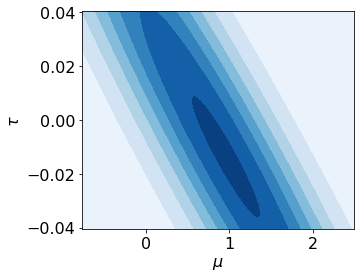

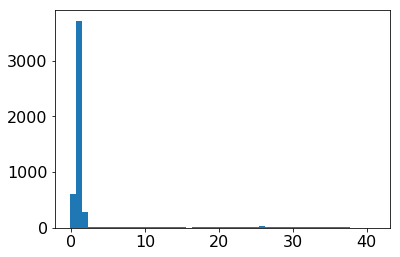

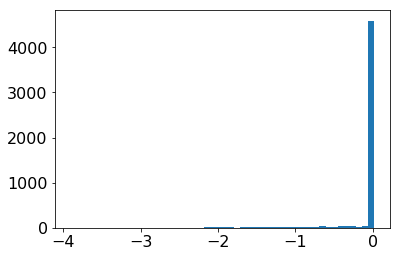

In [31]:
q = get_samples(sess, nbatches=10)

q1 = q[:, idx0]
q2 = q[:, idx1]

# q1_mean = q1.mean()
# q1_std = q1.std()

# q2_mean = q2.mean()
# q2_std = q2.std()

bbox = [q1_mean - 4*q1_std, q1_mean + 4*q1_std,
        q2_mean - 4*q2_std, q2_mean + 4*q2_std]

scatter(q1, q2, bbox, xlabel=xlabel, ylabel=ylabel)
kde(q1, q2, bbox, xlabel=xlabel, ylabel=ylabel)
hist(q1)
hist(q2)
    

## STAN VB

In [ ]:
q = stan_vb_samples
q1 = stan_vb_samples[:, idx0]
q2 = stan_vb_samples[:, idx1]


scatter(q1, q2, bbox, xlabel=xlabel, ylabel=ylabel)
kde(q1, q2, bbox, xlabel=xlabel, ylabel=ylabel)
hist(q1)
hist(q2)